#### Deep Recurrent neural networks architecture

RNNs are capable of modeling the temporal aspect of data by including additional weights in the model that create cycles in the network. This helps maintain a *state*. The concept of cycles explains the term *recurrence*, and this recurrence helps establish the concept of *memory* in these networks. Essentially, such networks facilitate the use of intermediate outputs at time step $t$ as inputs for time step $t+1$, while maintaining a hidden internal state. **These connections across time steps are called recurrent connections**.

while RNNs can remember the sequential information across short sequences, they tend to struggle with
long sequences due to the larger number of multiplications. *LSTM*s resolve this issue by controlling
their input and output using *gates*.

An LSTM layer essentially consists of various time-unfolded LSTM cells. Information passes from
one cell to another in the form of cell states. These cell states are controlled or manipulated using
multiplications and additions using the mechanism of gates

<img src=../images/LSTM_gates.png width=800>

-----
##### difference between vanilla RNNs and Gated ones:

a) in vanilla we have:
$$h_t = \tanh(W_{hh} h_{t-1} + W_{xh} x_t + b)$$
   1. This formulation blindly updates the hidden state at each time step, with no control over what to keep or what to forget.
   2. It leads to vanishing gradients in long sequences, making it hard to learn long-range dependencies.

b) Gates in LSTM:
LSTM maintain two things at each time step:
- a **hidden state** $h_t$ (what gets output)
- a **cell state** $c_t$ (long-term memory)
there are three gates in LSTM:
1. **Forget Gate**: Decides what to forget from the previous cell state $c_{t-1}$.
$$f_t = \sigma(W_f \cdot [h_{t-1}, x_t] + b_f)$$
2. **Input Gate**: Decides how much new information to write to the cell.
$$i_t = \sigma(W_i \cdot [h_{t-1}, x_t] + b_i)$$
and also update the cell state:
$$c_t = f_t \odot c_{t-1} + i_t \odot \tilde{c}_t$$
3. **Output Gate**: Decides what part of the memory should be output.
$$o_t = \sigma(W_o \cdot [h_{t-1}, x_t] + b_o)$$
and finally:
$$h_t = o_t \odot \tanh(c_t)$$


----

in *Stacked LSTMs*:

LSTM cells are, by their very nature, stacked in the time dimension of an LSTM layer. Stacking several
such layers in the space dimension provides them with the additional depth in space they need. The
downside of these models is that they are significantly slower to train due to the extra depth and extra
recurrent connections they have. Furthermore, the additional LSTM layers need to be unrolled (in
the time dimension) at every training iteration. Hence, training stacked recurrent models, in general,
is not parallelizable.

### GRUs:

The LSTM cell has two states – internal and external – as well as three different gates – input gate,
forget gate, and output gate. A similar type of cell, named a gated recurrent unit (GRU), was invented
in 2014 with the goal of learning long-term dependencies while effectively dealing with the exploding
and vanishing gradients problem.

<img src=../images/GRU-net.png width=800>

#### Training an RNN model using PyTorch for text classification task -sentiment analysis.

$?$ Tokenization, Embedding, Feature vectors:

$!$ Tokenization is the process of converting words into numerical tokens or integers, as we will see in
this exercise. Sentences are then equivalent to an array of numbers, each number in the ordered
array representing a word. While tokenization provides us with integer indices for each word, we
still want to represent each word as a vector of numbers – as a feature – in the feature space of words.
Why? Because the information contained in a word cannot just be represented by a single number.
*This process of representing words as vectors is called **embedding***, which we will also use later in
this exercise. An embedding matrix, which can be learned during model training, acts as a lookup
for word vectors. If a word has a token index of 123, then the embedding for that word is the vector
contained in row 123 of the embedding matrix.

In [1]:
import os
import time
import numpy as np
from tqdm import tqdm
from string import punctuation
from collections import Counter
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

torch.use_deterministic_algorithms(True)

In [2]:
# read sentiments and reviews data from the text files
review_list = []
label_list = []
for label in ['pos', 'neg']:
    for fname in tqdm(os.listdir(f'./aclImdb/train/{label}/')):
        if 'txt' not in fname:
            continue
        with open(os.path.join(f'./aclImdb/train/{label}/', fname), encoding="utf8") as f:
            review_list += [f.read()]
            label_list += [label]
print ('Number of reviews :', len(review_list))

100%|██████████| 12500/12500 [00:02<00:00, 4950.33it/s]

Number of reviews : 25000


In [3]:
# pre-processing review text
review_list = [review.lower() for review in review_list]
review_list = [''.join([letter for letter in review if letter not in punctuation]) for review in tqdm(review_list)]

# accumulate all review texts together
review_blob = ' '.join(review_list)

# generate a list of all words of all reviews
review_words = review_blob.split()

# get the word counts
count_words = Counter(review_words)

# sort words as per counts (decreasing order)
total_review_words = len(review_words)
sorted_review_words = count_words.most_common(total_review_words)

print(sorted_review_words[:10])

100%|██████████| 25000/25000 [00:01<00:00, 18183.37it/s]

[('the', 334691), ('and', 162228), ('a', 161940), ('of', 145326), ('to', 135042), ('is', 106855), ('in', 93028), ('it', 77099), ('i', 75719), ('this', 75190)]


Ideally, these non-nouns, also referred to as *stop words*, would be removed from the corpus
as they do not carry a lot of meaning. However, we will skip those advanced text-processing
steps to keep things simple.

In [4]:
# create word to integer (tokens) dictionary in order to encode text as numbers
vocab_to_token = {word:idx+1 for idx, (word, count) in enumerate(sorted_review_words)}
print(list(vocab_to_token.items())[:10])

[('the', 1), ('and', 2), ('a', 3), ('of', 4), ('to', 5), ('is', 6), ('in', 7), ('it', 8), ('i', 9), ('this', 10)]


In [5]:
review_tokenized = []
for review in review_list:
    review_tokenized.append([vocab_to_token[word] for word in review.split() if word in vocab_to_token])
print(review_list[0])
print()
print(review_tokenized[0])


for a movie that gets no respect there sure are a lot of memorable quotes listed for this gem imagine a movie where joe piscopo is actually funny maureen stapleton is a scene stealer the moroni character is an absolute scream watch for alan the skipper hale jr as a police sgt

[15, 3, 17, 11, 201, 56, 1165, 47, 242, 23, 3, 168, 4, 891, 4325, 3513, 15, 10, 1514, 822, 3, 17, 112, 884, 14623, 6, 155, 161, 7307, 15816, 6, 3, 134, 20049, 1, 32064, 108, 6, 33, 1492, 1943, 103, 15, 1550, 1, 18993, 9055, 1809, 14, 3, 549, 6906]


In [6]:
# encode setiments as 0 and 1
encoded_label_list = [1 if label == 'pos' else 0 for label in label_list]
review_len = [len(review) for review in review_tokenized]

review_tokenized = [review_tokenized[i] for i, l in enumerate(review_len) if l > 0]
encoded_label_list = np.array([encoded_label_list[i] for i, l in enumerate(review_len)], dtype=np.float32)

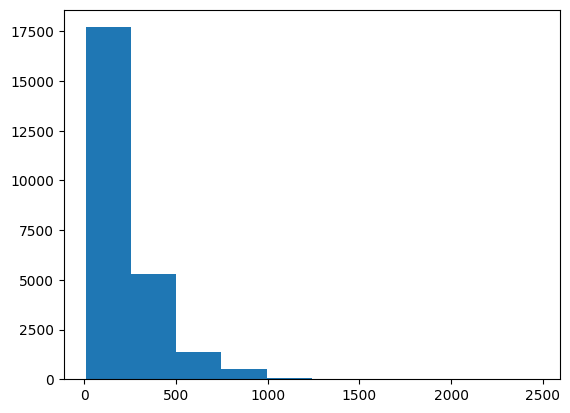

In [7]:
def pad_sequence(review_tokenized, sequence_length):
    """
        returns the tokenized review sequences padded with 0's
        or truncated to the sequence_lenght
    """
    padded_reviews = np.zeros((len(review_tokenized), sequence_length), dtype=np.int64)
    for idx, review in enumerate(review_tokenized):
        review_len = len(review)

        if review_len <= sequence_length:
            zeroes = list(np.zeros(sequence_length - review_len))
            new_sequence = zeroes+review
        elif review_len > sequence_length:
            new_sequence = review[0:sequence_length]

        padded_reviews[idx, :] = new_sequence

    return padded_reviews

sequence_length = 512
padded_reviews = pad_sequence(review_tokenized, sequence_length)
plt.hist(review_len);

In [8]:
train_val_split = 0.75
train_X = padded_reviews[:int(train_val_split*len(padded_reviews))]
train_y = encoded_label_list[:int(train_val_split*len(padded_reviews))]
validation_X = padded_reviews[int(train_val_split*len(padded_reviews)):]
validation_y = encoded_label_list[int(train_val_split*len(padded_reviews)):]

In [9]:
# generate torch datasets
train_dataset = TensorDataset(torch.from_numpy(train_X).to(device), torch.from_numpy(train_y).to(device))
validation_dataset = TensorDataset(torch.from_numpy(validation_X).to(device), torch.from_numpy(validation_y).to(device))


batch_size = 32
# torch dataloaders (shuffle data)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True)

In [10]:
# get a batch of train data
train_data_iter = iter(train_dataloader)
X_example, y_example = next(train_data_iter)
print('Example Input size: ', X_example.size()) # batch_size, seq_length
print('Example Input:\n', X_example)
print()
print('Example Output size: ', y_example.size()) # batch_size
print('Example Output:\n', y_example)

Example Input size:  torch.Size([32, 512])
Example Input:
 tensor([[   0,    0,    0,  ...,   80,   15, 4116],
        [   0,    0,    0,  ...,   20,   10,   28],
        [   0,    0,    0,  ...,   44,   22,   68],
        ...,
        [   0,    0,    0,  ...,    2,   37, 2632],
        [   0,    0,    0,  ...,   35, 1033,  476],
        [   0,    0,    0,  ..., 1493,    5,   81]])

Example Output size:  torch.Size([32])
Example Output:
 tensor([1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 0.,
        1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 0., 1., 0., 1.])


In [12]:
class RNN(nn.Module):
    def __init__(self, input_dimension, embedding_dimension, hidden_dimension, output_dimension):
        super().__init__()
        self.embedding_layer = nn.Embedding(input_dimension, embedding_dimension)  
        self.rnn_layer = nn.RNN(embedding_dimension, hidden_dimension, num_layers=1)
        self.fc_layer = nn.Linear(hidden_dimension, output_dimension)
        
    def forward(self, sequence):
        # sequence shape = (sequence_length, batch_size)
        embedding = self.embedding_layer(sequence)  
        # embedding shape = [sequence_length, batch_size, embedding_dimension]
        output, hidden_state = self.rnn_layer(embedding)
        # output shape = [sequence_length, batch_size, hidden_dimension]
        # hidden_state shape = [1, batch_size, hidden_dimension]
        final_output = self.fc_layer(hidden_state[-1,:,:].squeeze(0))      
        return final_output
    
input_dimension = len(vocab_to_token)+1 # +1 to account for padding
embedding_dimension = 100
hidden_dimension = 32
output_dimension = 1

rnn_model = RNN(input_dimension, embedding_dimension, hidden_dimension, output_dimension)

optim = torch.optim.Adam(rnn_model.parameters())
loss_func = nn.BCEWithLogitsLoss() # a numerically stable computation of a sigmoid function, followed by a binary cross-entropy

rnn_model = rnn_model.to(device)
loss_func = loss_func.to(device)

In [14]:
def accuracy_metric(predictions, ground_truth):
    """
        Returns 0 or 1 for the given set of predictions and ground truth
    """
    rounded_predictions = torch.round(torch.sigmoid(predictions))
    success = (rounded_predictions == ground_truth).float()
    acc = success.sum()/len(success)
    return acc

In [15]:
def train(model, dataloader, optim, loss_func):
    loss = 0
    accuracy = 0
    model.train()
    for sequence, sentiment in dataloader:
        optim.zero_grad()
        preds = model(sequence.T).squeeze(1)
        
        loss_curr = loss_func(preds, sentiment)
        accuracy_curr = accuracy_metric(preds, sentiment)
        
        loss_curr.backward()
        optim.step()

        loss += loss_curr.item()
        accuracy += accuracy_curr.item()

    return loss/len(dataloader), accuracy/len(dataloader)

In [16]:
def validate(model, dataloader, loss_func):
    loss = 0
    accuracy = 0
    model.eval()
    with torch.no_grad():
        for sequence, sentiment in dataloader:
            preds = model(sequence.T).squeeze(1)
            
            loss_curr = loss_func(preds, sentiment)
            accuracy_curr = accuracy_metric(preds, sentiment)

            loss += loss_curr.item()
            accuracy += accuracy_curr.item()

    return loss/len(dataloader), accuracy/len(dataloader)

In [17]:
num_epoch = 5
best_validation_score = float('inf')
for ep in range(num_epoch):
    time_start = time.time()
    train_loss, train_accuracy = train(rnn_model, train_dataloader, optim, loss_func)
    validation_loss, validation_accuracy = validate(rnn_model, validation_dataloader, loss_func)
    time_end = time.time()
    time_elapsed = time_end - time_start
    if validation_loss < best_validation_score:
        best_validation_score = validation_loss
        torch.save(rnn_model.state_dict(), 'rnn_model.pt')
    print(f'Epoch {ep+1}/{num_epoch} | Time: {time_elapsed:.2f}s')
    print(f'Train Loss: {train_loss:.4f} | Train Accuracy: {train_accuracy:.4f}')
    print(f'Validation Loss: {validation_loss:.4f} | Validation Accuracy: {validation_accuracy:.4f}')
    print('-'*50)

Epoch 1/5 | Time: 24.05s
Train Loss: 0.6235 | Train Accuracy: 0.6663
Validation Loss: 1.0162 | Validation Accuracy: 0.2065
--------------------------------------------------
Epoch 2/5 | Time: 23.51s
Train Loss: 0.5302 | Train Accuracy: 0.7404
Validation Loss: 0.8853 | Validation Accuracy: 0.4906
--------------------------------------------------
Epoch 3/5 | Time: 24.01s
Train Loss: 0.4322 | Train Accuracy: 0.8086
Validation Loss: 0.7966 | Validation Accuracy: 0.5952
--------------------------------------------------
Epoch 4/5 | Time: 24.28s
Train Loss: 0.4049 | Train Accuracy: 0.8273
Validation Loss: 0.9485 | Validation Accuracy: 0.5321
--------------------------------------------------
Epoch 5/5 | Time: 23.96s
Train Loss: 0.3078 | Train Accuracy: 0.8770
Validation Loss: 0.8093 | Validation Accuracy: 0.6418
--------------------------------------------------


In [18]:
def sentiment_inference(model, sentence):
    model.eval()

    # text transformation
    sentence = sentence.lower()
    sentence = ''.join([c for c in sentence if c not in punctuation])
    tokenized = [vocab_to_token.get(token, 0) for token in sentence.split()]
    tokenized = np.pad(tokenized, (512-len(tokenized), 0), 'constant')

    # model inference
    model_input = torch.LongTensor(tokenized).to(device)
    model_input = model_input.unsqueeze(1)
    pred = torch.sigmoid(model(model_input))

    return pred.item()

In [29]:
print(sentiment_inference(rnn_model, "This film is horrible"))
print(sentiment_inference(rnn_model, "Director tried too hard but this film is bad"))
print(sentiment_inference(rnn_model, "This film will be houseful for weeks"))
print(sentiment_inference(rnn_model, "I just really loved the movie"))
print(sentiment_inference(rnn_model, "are you kidding me?")) #!!
print(sentiment_inference(rnn_model, "Do Not Watch This Movie")) #!! # so the model is still too basic

0.42833492159843445
0.24501614272594452
0.9373890161514282
0.9171954393386841
0.9674911499023438
0.8580657839775085


further improvement:
- work on data processing and maybe skip the "stop words"
- encoder-decoder model maybe?
- maybe using Bidirectional LSTMs rather than unidirectional one? --> [here](./bidirectional_lstm.ipynb)
- maybe text processing and feature extraction through CNNs and then use RNNs for convergence?